In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

In [6]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [7]:
data_dir = Path('D:\input/')
trn_file = data_dir / 'train.csv'
seed = 42

In [8]:
trn = pd.read_csv(trn_file, index_col = 0)
print(trn.shape)
trn.head()

(320000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


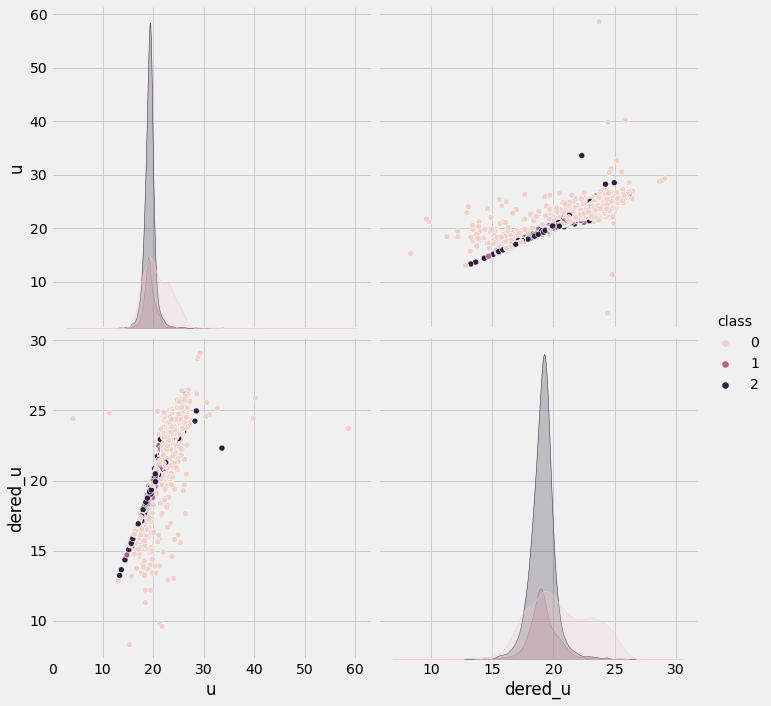

In [40]:
sns.pairplot(trn.sample(n=10000), vars = ['u', 'dered_u'], hue = 'class', size = 5)

In [10]:
X = trn[trn['class'] !=0][['u']].values
y = trn[trn['class'] !=0]['dered_u'].values
print(X.shape, y.shape)

(200004, 1) (200004,)


In [11]:
rmse = lambda y, p: np.sqrt(np.mean((y - p) ** 2))

In [12]:
alpha = .001
theta0 = .1
theta1 = .1
epoch = 4

In [13]:
x = X.flatten()
print(x.shape)

(200004,)


In [41]:
rmses = []
for i in tqdm(range(epoch)):
    for x_i, y_i in zip(x,y):
        p_i = theta0 + theta1 * x_i
        theta0 = theta0 + alpha * (y_i - p_i)
        theta1 = theta1 + alpha * (y_i - p_i) *x_i
    rmses.append(rmse(y, theta0 + theta1 *x))

In [15]:
theta1, theta0

(0.9362306162023849, 1.1088813148478316)

In [16]:
rmses

[0.25618215910731906,
 0.25492967552380746,
 0.25461791287963526,
 0.25454708923095914]

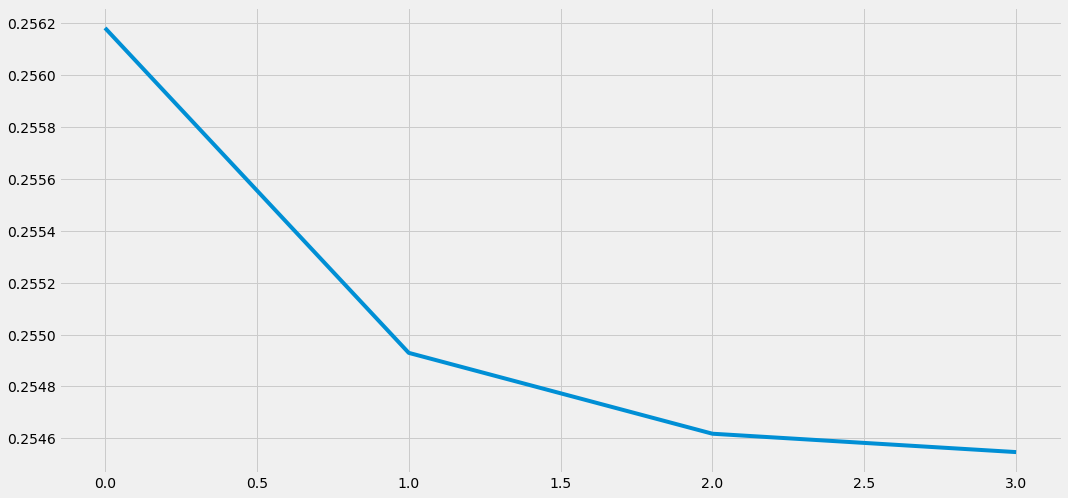

In [17]:
plt.plot(rmses)

Text(0, 0.5, 'dered_u')

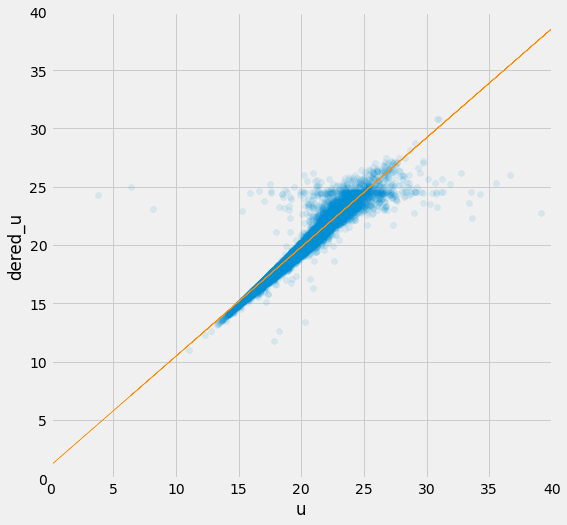

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(X, y, alpha=.1)
plt.plot(X, theta0 + theta1 * x, color = 'darkorange', linewidth = .5)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel('u')
plt.ylabel('dered_u')

In [22]:
from sklearn.linear_model import LinearRegression

In [24]:
lr = LinearRegression()
lr.fit(X, y)
p = lr.predict(X)

In [25]:
rmse(y, p)

0.2522450693360897

In [26]:
lr.coef_, lr.intercept_

(array([0.9320425]), 1.155642417862527)

Text(0, 0.5, 'dered_u')

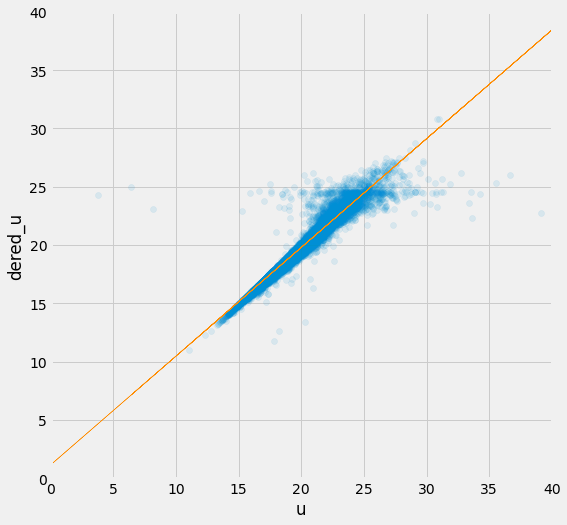

In [27]:
plt.figure(figsize = (8,8))
plt.scatter(X, y, alpha = .1)
plt.plot(X, p, color = 'darkorange', linewidth = .5)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel('u')
plt.ylabel('dered_u')

In [28]:
X = trn[trn['class']!=0].drop('class', axis=1)
y = trn[trn['class']!=0]['class'].values -1

In [29]:
np.unique(y)

array([0, 1], dtype=int64)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

In [31]:
lr = LogisticRegression()
lr.fit(X, y)
p = lr.predict_proba(X)[:, 1]

In [32]:
lr.coef_, lr.intercept_

(array([[ 0.85053662,  0.08972204, -1.86305137,  0.51621378, -0.52970308,
         -1.53965022,  2.24737771, -0.05971821, -1.36975551,  0.54217032,
         -0.61562274,  0.11166829, -0.12864329, -0.13114676, -0.13369801,
         -0.12873519, -0.12992466, -0.1324057 ]]),
 array([0.22003707]))

In [33]:
log_loss(y, p)

0.3656587451944277

In [34]:
roc_auc_score(y, p)

0.8758121117299011

In [35]:
from sklearn.metrics import roc_curve, precision_recall_curve

In [36]:
def plot_roc_curve(y, p):
    fpr, tpr, _ = roc_curve(y, p)
    
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
def plot_pr_curve(y, p):
    precision, recall, _ = precision_recall_curve(y, p)
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step = 'post', alpha = 0.2, color = 'b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

Text(0.5, 1.0, 'Precision-Recall Curve')

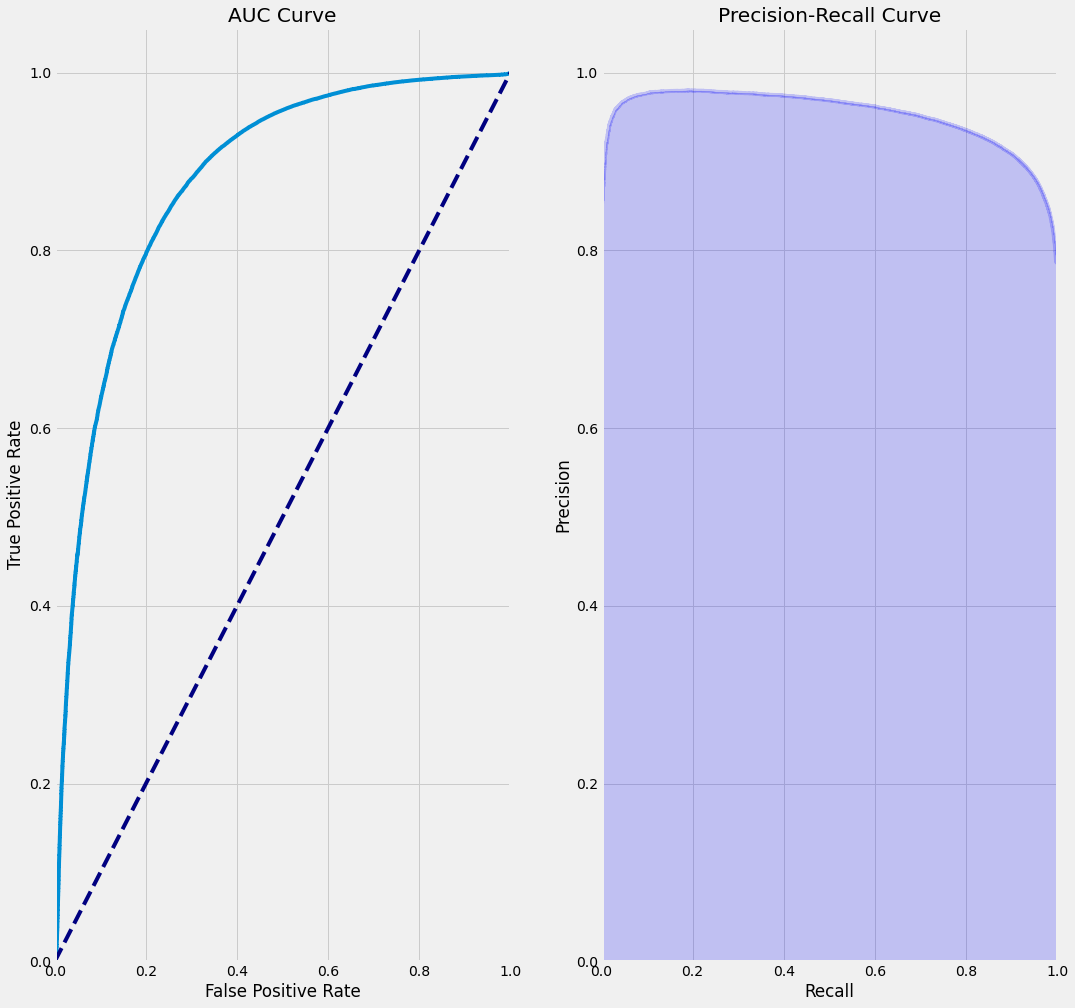

In [38]:
plt.figure(figsize = (16, 16))
plt.subplot(1, 2, 1)
plot_roc_curve(y, p);
plt.title('AUC Curve')
plt.subplot(1, 2, 2)
plot_pr_curve(y, p);
plt.title('Precision-Recall Curve')